<a href="https://colab.research.google.com/github/luiseduaardo/PneuModel/blob/main/notebooks/treinamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import zipfile
from google.colab import drive

drive.mount('/content/drive')

caminho_zip_drive = '/content/drive/MyDrive/PneuModel/ligia-compviz.zip'
caminho_local_zip = '/content/ligia-compviz.zip'

if os.path.exists(caminho_zip_drive):
    !cp "{caminho_zip_drive}" "{caminho_local_zip}"

    with zipfile.ZipFile(caminho_local_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')

    print("✅ Sucesso: Dataset extraído em /content/dataset")
else:
    print("❌ Erro: O arquivo não foi encontrado no caminho especificado.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Sucesso: Dataset extraído em /content/dataset


In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

path_treinamento = "./dataset/train/train"

#treino
train_generator = train_datagen.flow_from_directory(
    path_treinamento,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='training'
)
labels = train_generator.classes
weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(weights))

#validação
val_generator = train_datagen.flow_from_directory(
    path_treinamento,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [tf.keras.metrics.AUC(name='auc')]
)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [26]:
checkpoint_path = '/content/drive/MyDrive/PneuModel/melhor_modelo_pneumonia.h5'

early_stop = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    mode='max'
)

callbacks_list = [early_stop, checkpoint, reduce_lr]

In [27]:
history = model.fit(
    train_generator,
    epochs=20, # Limite alto, mas geralmente o EarlyStopping para antes
    validation_data=val_generator,
    callbacks=callbacks_list,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.8643 - loss: 0.4450

66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - auc: 0.8652 - loss: 0.4435 - val_auc: 0.9626 - val_loss: 0.5528 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - auc: 0.9574 - loss: 0.2598 - val_auc: 0.9485 - val_loss: 0.5381 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9666 - loss: 0.2316

66/66 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - auc: 0.9666 - loss: 0.2316 - val_auc: 0.9699 - val_loss: 0.4671 - learning_rate: 0.0010
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - auc: 0.9669 - loss: 0.2246 - val_auc: 0.9658 - val_loss: 0.4202 - learning_rate: 0.0010
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9729 - loss: 0.2050

66/66 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - auc: 0.9729 - loss: 0.2049 - val_auc: 0.9795 - val_loss: 0.3227 - learning_rate: 0.0010
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9754 - loss: 0.1950

66/66 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - auc: 0.9754 - loss: 0.1950 - val_auc: 0.9815 - val_loss: 0.2645 - learning_rate: 0.0010
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9729 - loss: 0.2102

66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - auc: 0.9729 - loss: 0.2100 - val_auc: 0.9815 - val_loss: 0.2146 - learning_rate: 0.0010
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - auc: 0.9787 - loss: 0.1823 - val_auc: 0.9807 - val_loss: 0.1811 - learning_rate: 0.0010
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9807 - loss: 0.1734

66/66 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - auc: 0.9807 - loss: 0.1734 - val_auc: 0.9832 - val_loss: 0.1644 - learning_rate: 0.0010
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - auc: 0.9795 - loss: 0.1799 - val_auc: 0.9810 - val_loss: 0.1640 - learning_rate: 0.0010
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - auc: 0.9796 - loss: 0.1762 - val_auc: 0.9802 - val_loss: 0.1844 - learning_rate: 0.0010
Epoch 12/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9774 - loss: 0.1889

66/66 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - auc: 0.9774 - loss: 0.1889 - val_auc: 0.9890 - val_loss: 0.1270 - learning_rate: 0.0010
Epoch 13/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - auc: 0.9807 - loss: 0.1702 - val_auc: 0.9819 - val_loss: 0.1964 - learning_rate: 0.0010
Epoch 14/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - auc: 0.9813 - loss: 0.1710 - val_auc: 0.9844 - val_loss: 0.1509 - learning_rate: 0.0010
Epoch 15/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - auc: 0.9794 - loss: 0.1767 - val_auc: 0.9796 - val_loss: 0.1617 - learning_rate: 0.0010
Epoch 16/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - auc: 0.9804 - loss: 0.1723 - val_auc: 0.9854 - val_loss: 0.1463 - learning_rate: 2.0000e-04
Epoch 17/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - auc: 0.9804 - loss: 0.1763 - val_auc: 0.9883 - val_loss: 0.1324 - learning_rate: 2.0000e-04


In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

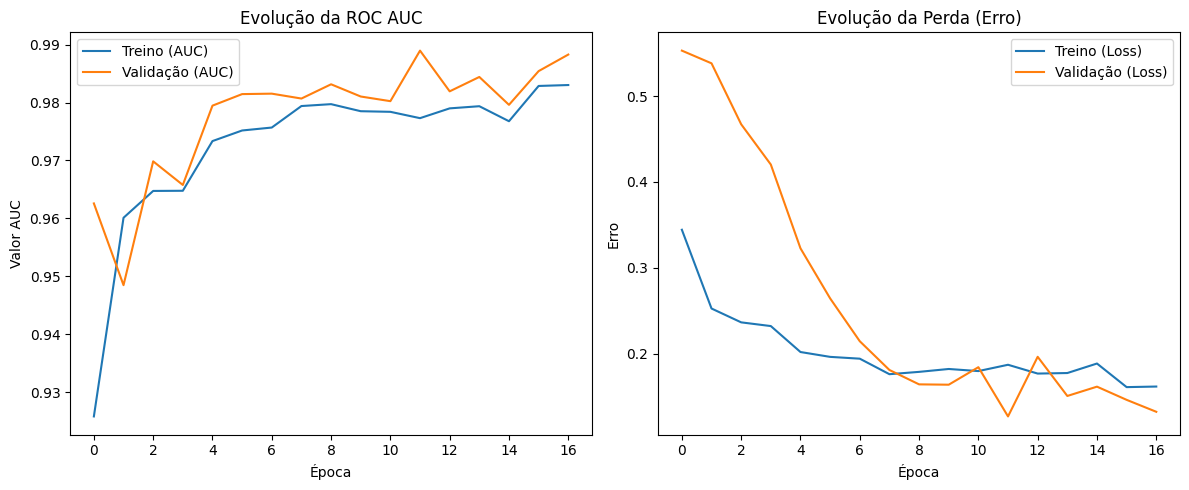

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Treino (AUC)')
plt.plot(history.history['val_auc'], label='Validação (AUC)')
plt.title('Evolução da ROC AUC')
plt.xlabel('Época')
plt.ylabel('Valor AUC')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino (Loss)')
plt.plot(history.history['val_loss'], label='Validação (Loss)')
plt.title('Evolução da Perda (Erro)')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.legend()

plt.tight_layout()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


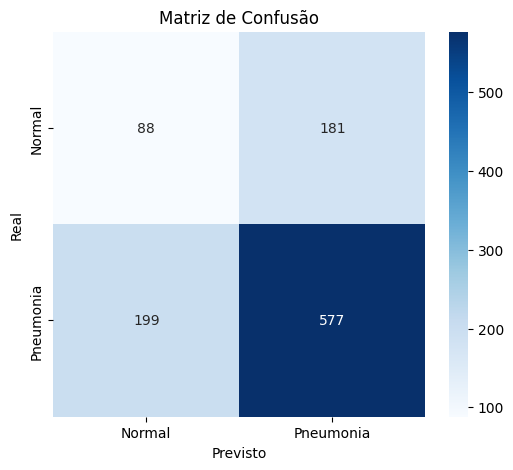

              precision    recall  f1-score   support

      Normal       0.31      0.33      0.32       269
   Pneumonia       0.76      0.74      0.75       776

    accuracy                           0.64      1045
   macro avg       0.53      0.54      0.53      1045
weighted avg       0.64      0.64      0.64      1045



In [30]:
val_generator.reset()
predictions = model.predict(val_generator)

y_pred = (predictions > 0.5).astype(int)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))